# FX Value Strategy - Pairs Trading
## Authors - Joel Thomas, Victoria Zhang, Liam Horrocks

### Module imports

In [1]:
# Additional libraries required: numpy, pandas, matplotlib, scipy, statsmodels
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
from time import strptime, mktime
from datetime import datetime
from scipy.stats import kurtosis
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [2]:
# Use this function to obtain data from Refinitiv DSA
def get_data_request(url, requestData):
    '''make HTTP GET request'''
    dResp = requests.get(url, headers = {'X-api-key': access_token}, params = requestData);       

    
    if dResp.status_code != 200:
        print("Unable to get data. Code %s, Message: %s" % (dResp.status_code, dResp.text));
    else:
        print("Data access successful")
        jResp = json.loads(dResp.text);
        return jResp

### G10 FX Spot Rates and Forward Points

In [3]:
# Spot rates
ric_spot_fx_list = ["EUR=", "CAD=", "JPY=", "SEK=", "CHF=", "GBP="]
spot_fx_df = []
# Forward points for forwards expiring in 1 week
ric_fx_fp_1w_list = ["EURSW=", "CADSW=", "JPYSW=", "SEKSW=", "CHFSW=", "GBPSW="]
fx_fp_1w_df = []
# Forward points for forwards expiring overnight (closest to spot price because forward price --> spot price as t --> expiration)
ric_fx_fp_on_list = ["EURON=", "CADON=", "JPYON=", "SEKON=", "CHFON=", "GBPON="]
fx_fp_on_df = []

In [4]:
# Maximum sample period based on available data
start_date = "2016-11-01"
end_date = "2019-06-30"

In [5]:
# Converts string date index to datetime date index
def make_datetime_index(index):
    datetime_index = []
    for date in index:
        datetime_index.append(datetime.fromtimestamp((mktime(strptime(date, "%Y-%m-%d")))))
    return datetime_index

### Retrieving G10 FX spot rates data

In [6]:
for ric in ric_spot_fx_list:
    RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ric
    # personal key for Data Science Accelerator access to Pricing Data
    access_token = "" # ADD PERSONAL ACCESS TOKEN FROM REFINITIV DSA
    # fields: BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS
    requestData = {"interval": "P1D", "start": start_date, "end": end_date, "fields": 'BID, ASK'}

    jResp = get_data_request(RESOURCE_ENDPOINT, requestData)

    if jResp is not None:
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names)
        df.set_index("DATE", inplace=True)
        df.index = make_datetime_index(df.index)
        # Hierarchical columns
        df.columns = pd.MultiIndex.from_product([[ric[:3]], ['BID', 'ASK']])
        # Converting EURUSD and GBPUSD to USDEUR and USDGBP for quote name symmetry with other exchange rates 
        if "EUR" in ric or "GBP" in ric:
            # When flipping a currency rate, bids become asks and asks become bids
            true_bid = 1/df[(ric[:3], "ASK")]
            true_ask = 1/df[(ric[:3], "BID")]
            df[(ric[:3], "BID")] = true_bid
            df[(ric[:3], "ASK")] = true_ask
        spot_fx_df.append(df)

spot_fx_df = pd.concat(spot_fx_df, axis=1).sort_index()
# Inferred frequency should be "B" - business day frequency
spot_fx_df = spot_fx_df.asfreq(spot_fx_df.index.inferred_freq).ffill()
print("\n")

Data access successful
Data access successful
Data access successful
Data access successful
Data access successful
Data access successful




### Retrieving forwards points data for G10 FX forwards expiring in 1 week

In [7]:
for ric in ric_fx_fp_1w_list:
    RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ric
    # personal key for Data Science Accelerator access to Pricing Data
    access_token = "" # ADD PERSONAL ACCESS TOKEN FROM REFINITIV DSA
    # fields: BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS
    requestData = {"interval": "P1D", "start": start_date, "end": end_date, "fields": 'BID, ASK'}

    jResp = get_data_request(RESOURCE_ENDPOINT, requestData)

    if jResp is not None:
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names)
        df.set_index("DATE", inplace=True)
        df.index = make_datetime_index(df.index)
        # Hierarchical columns
        df.columns = pd.MultiIndex.from_product([[ric[:3]], ['BID', 'ASK']])
        # Converting EURUSD and GBPUSD to USDEUR and USDGBP for quote name symmetry with other exchange rates 
        if "EUR" in ric or "GBP" in ric:
            # When flipping a currency rate, bids become asks and asks become bids
            true_bid = 1/df[(ric[:3], "ASK")]
            true_ask = 1/df[(ric[:3], "BID")]
            df[(ric[:3], "BID")] = true_bid
            df[(ric[:3], "ASK")] = true_ask
        fx_fp_1w_df.append(df)
        
fx_fp_1w_df = pd.concat(fx_fp_1w_df, axis=1).sort_index()
# Inferred frequency should be "B" - business day frequency
fx_fp_1w_df = fx_fp_1w_df.asfreq(fx_fp_1w_df.index.inferred_freq).ffill()
print("\n")

Data access successful
Data access successful
Data access successful
Data access successful
Data access successful
Data access successful




### Retrieving forwards points data for G10 FX forwards expiring overnight

In [8]:
for ric in ric_fx_fp_on_list:
    RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ric
    # personal key for Data Science Accelerator access to Pricing Data
    access_token = "" # ADD PERSONAL ACCESS TOKEN FROM REFINITIV DSA
    # fields: BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS
    requestData = {"interval": "P1D", "start": start_date, "end": end_date, "fields": 'BID, ASK'}

    jResp = get_data_request(RESOURCE_ENDPOINT, requestData)

    if jResp is not None:
        data = jResp[0]['data']
        headers = jResp[0]['headers']  
        names = [headers[x]['name'] for x in range(len(headers))]
        df = pd.DataFrame(data, columns=names)
        df.set_index("DATE", inplace=True)
        df.index = make_datetime_index(df.index)
        # Hierarchical columns
        df.columns = pd.MultiIndex.from_product([[ric[:3]], ['BID', 'ASK']])
        # Converting EURUSD and GBPUSD to USDEUR and USDGBP for quote name symmetry with other exchange rates 
        if "EUR" in ric or "GBP" in ric:
            # When flipping a currency rate, bids become asks and asks become bids
            true_bid = 1/df[(ric[:3], "ASK")]
            true_ask = 1/df[(ric[:3], "BID")]
            df[(ric[:3], "BID")] = true_bid
            df[(ric[:3], "ASK")] = true_ask
        fx_fp_on_df.append(df)
        
fx_fp_on_df = pd.concat(fx_fp_on_df, axis=1).sort_index()
# Inferred frequency should be "B" - business day frequency
fx_fp_on_df = fx_fp_on_df.asfreq(fx_fp_on_df.index.inferred_freq).ffill()
print("\n")

Data access successful
Data access successful
Data access successful
Data access successful
Data access successful
Data access successful




In [9]:
currencies = ["EUR", "CAD", "JPY", "SEK", "CHF", "GBP"]
# Store 1 week and overnight expiring outright forwards prices
fx_fw_1w_df = []
fx_fw_on_df = []

In [10]:
for currency in currencies:
    # Outright forward prices for forwards expiring in 1 week
    bid_prices = spot_fx_df[currency]["BID"] + fx_fp_1w_df[currency]["BID"]*0.0001
    ask_prices = spot_fx_df[currency]["ASK"] + fx_fp_1w_df[currency]["ASK"]*0.0001
    prices = (bid_prices + ask_prices)/2
    df = pd.concat((bid_prices, ask_prices, prices), axis=1)
    df.columns = pd.MultiIndex.from_product([[currency], ['BID', 'ASK', 'PRICE']])
    fx_fw_1w_df.append(df)
    
    # Outright forward prices for forwards expiring overnight
    bid_prices = spot_fx_df[currency]["BID"] + fx_fp_on_df[currency]["BID"]*0.0001
    ask_prices = spot_fx_df[currency]["ASK"] + fx_fp_on_df[currency]["ASK"]*0.0001
    prices = (bid_prices + ask_prices)/2
    df = pd.concat((bid_prices, ask_prices, prices), axis=1)
    df.columns = pd.MultiIndex.from_product([[currency], ['BID', 'ASK', 'PRICE']])
    fx_fw_on_df.append(df)

In [11]:
fx_fw_1w_df = pd.concat(fx_fw_1w_df, axis=1).sort_index()
fx_fw_1w_df.tail()

EUR                           CAD                      \
                 BID       ASK     PRICE       BID       ASK     PRICE   
2019-06-24  0.877207  0.877515  0.877361  1.317355  1.317778  1.317567   
2019-06-25  0.879597  0.879907  0.879752  1.316347  1.316777  1.316562   
2019-06-26  0.879443  0.879676  0.879560  1.312131  1.312569  1.312350   
2019-06-27  0.879368  0.879677  0.879522  1.309175  1.309290  1.309233   
2019-06-28  0.879368  0.879677  0.879522  1.308766  1.309181  1.308974   

                   JPY                               SEK                      \
                   BID         ASK       PRICE       BID       ASK     PRICE   
2019-06-24  107.279263  107.309301  107.294282  9.272386  9.276274  9.274330   
2019-06-25  107.169179  107.199209  107.184194  9.270996  9.274904  9.272950   
2019-06-26  107.769229  107.799254  107.784241  9.255785  9.259001  9.257393   
2019-06-27  107.779369  107.809389  107.794379  9.270623  9.273912  9.272268   
2019-06-28  107.879359  107.909399  107.894379  9.276383  9.279672  9.278028   

                 CHF                           GBP                      
                 BID       ASK     PRICE       BID       ASK     PRICE  
2019-06-24  0.971081  0.971511  0.971296  0.784825  0.785011  0.784918  
2019-06-25  0.974372  0.974802  0.974587  0.787356  0.787605  0.787480  
2019-06-26  0.977245  0.977375  0.977310  0.787916  0.788165  0.788040  
2019-06-27  0.975641  0.976061  0.975851  0.788790  0.788977  0.788883  
2019-06-28  0.975332  0.975772  0.975552  0.787609  0.787858  0.787733

In [12]:
fx_fw_on_df = pd.concat(fx_fw_on_df, axis=1).sort_index()
fx_fw_on_df.tail()

EUR                           CAD                      \
                 BID       ASK     PRICE       BID       ASK     PRICE   
2019-06-24  0.877295  0.877619  0.877457  1.317644  1.318095  1.317870   
2019-06-25  0.879685  0.880016  0.879851  1.316649  1.317099  1.316874   
2019-06-26  0.879533  0.879775  0.879654  1.312445  1.312896  1.312671   
2019-06-27  0.879450  0.879799  0.879625  1.309445  1.309595  1.309520   
2019-06-28  0.879386  0.879696  0.879541  1.308805  1.309255  1.309030   

                   JPY                               SEK                      \
                   BID         ASK       PRICE       BID       ASK     PRICE   
2019-06-24  107.279910  107.309940  107.294925  9.277106  9.280184  9.278645   
2019-06-25  107.169914  107.199934  107.184924  9.276018  9.279218  9.277618   
2019-06-26  107.769909  107.799939  107.784924  9.260001  9.263101  9.261551   
2019-06-27  107.779901  107.809946  107.794924  9.274971  9.278071  9.276521   
2019-06-28  107.878685  107.908715  107.893700  9.278078  9.283068  9.280573   

                 CHF                           GBP                      
                 BID       ASK     PRICE       BID       ASK     PRICE  
2019-06-24  0.971700  0.972120  0.971910  0.784953  0.785163  0.785058  
2019-06-25  0.975108  0.975511  0.975310  0.787496  0.787749  0.787622  
2019-06-26  0.977900  0.978020  0.977960  0.788049  0.788312  0.788180  
2019-06-27  0.976201  0.976621  0.976411  0.788908  0.789119  0.789014  
2019-06-28  0.975555  0.976105  0.975830  0.787629  0.787887  0.787758

### Useful functions

In [13]:
# Finds optimal VAR lag structure using Hannan-Quin Information Criterion
def find_max_lag_var(result_summary):
    for index in range(len(result_summary)):
        # Index of 4 accesses HQ IC results
        if "*" in result_summary[index][4]:
            return index

In [14]:
# Finds existence of a cointegrating relationship between two currency pairs in the last 6 months using Johansen Cointegration test
def find_coint_relationship(trace_stats, crit_vals):
    # At most 2 stages because bivariate system
    stage_1 = 0
    stage_2 = 1
    # Index 1 is to compare to 5% critical value
    # Test null of no cointegrating relationship
    if trace_stats[stage_1] > crit_vals[stage_1][1]:
        # Reject null of no cointegrating relationship (stage 1) --> test null of at most one cointegrating relationship (stage 2)
        if trace_stats[stage_2] > crit_vals[stage_2][1]:
            # Reject null of at most one cointegrating relationship --> all variables stationary
            return 2
        # Fail to reject null --> at most one cointegration relationship
        else:
            return 1
    # Fail to reject null --> no cointegrating relationship
    else:
        return 0

In [15]:
# Plots a cointegrating pairs' normalised variables
def plot_cointegrating_pairs(t, fw_prices_1, fw_prices_2, spread):
    plt.figure(figsize=(10, 6))
    plt.plot(fw_prices_1.index, (fw_1w_prices_1 - np.mean(fw_1w_prices_1))/np.std(fw_1w_prices_1), label=fw_prices_1.name) # fw_prices_1 normalised
    plt.plot(fw_prices_2.index, (fw_1w_prices_2 - np.mean(fw_1w_prices_2))/np.std(fw_1w_prices_2), label=fw_prices_2.name) # fw_prices_2 normalised
    plt.plot(fw_prices_2.index[-1], spread[-1], marker="o", markersize=5, color="red")
    plt.title("DAY: %d" % t)
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

### Creating custom backtester

In [16]:
# Custom function for opening a new trade, records days elapsed, short pair, short pair price, long pair, long pair price, positions and contract sizes
def open_trade(open_trades_dict, coint_pair, short_price, long_price):
    for existing_coint_pair in open_trades_dict:
        # Do not open another trade on same cointegrating pair if an open trade already exists unless opening a reverse position
        if sorted(coint_pair) == sorted(existing_coint_pair) and open_trades_dict[existing_coint_pair]["Days elapsed"] != 7:
            return
        elif sorted(coint_pair) == sorted(existing_coint_pair) and open_trades_dict[existing_coint_pair]["Days elapsed"] == 7:
            short_pair = existing_coint_pair[0]
            long_pair = existing_coint_pair[1]
            open_trades_dict[existing_coint_pair][short_pair]["Close price"] = short_price
            open_trades_dict[existing_coint_pair][long_pair]["Close price"] = long_price
            return

    open_trades_dict[coint_pair] = {}
    open_trades_dict[coint_pair]["Days elapsed"] = 0
    short_pair = coint_pair[0]
    long_pair = coint_pair[1]

    open_trades_dict[coint_pair][short_pair] = {}
    open_trades_dict[coint_pair][short_pair]["Open price"] = short_price
    open_trades_dict[coint_pair][short_pair]["Position"] = "SHORT"

    open_trades_dict[coint_pair][long_pair] = {}
    open_trades_dict[coint_pair][long_pair]["Open price"] = long_price
    open_trades_dict[coint_pair][long_pair]["Position"] = "LONG"

In [17]:
# Increases days elapsed of an open trade every day
def increase_open_trades_days_elapsed(open_trades_dict):
    for coint_pair in open_trades_dict:
        open_trades_dict[coint_pair]["Days elapsed"] += 1

In [18]:
# Closes an open trade on the 7th day due to 1 week forwards maturing by buying forwards expiring overnight and holding both to expiration
def close_open_trade(open_trades_dict, spot_fx_df, t, raw_profit_list, num_trades, num_wins, num_losses):
    # Total profit for a single day
    total_profit = 0
    for coint_pair in list(open_trades_dict.keys()):
        # Profit after closing all positions for two cointegrating pairs
        profit = 0
        if open_trades_dict[coint_pair]["Days elapsed"] == 7:
            # Reverse 1 week short position by opening overnight long position
            short_pair = coint_pair[0]
            short_open_price = open_trades_dict[coint_pair][short_pair]["Open price"]
            short_close_price = open_trades_dict[coint_pair][short_pair]["Close price"]
            short_profit = (short_open_price - short_close_price)/short_close_price
            # Positive profit --> win trade, otherwise loss
            if short_profit > 0:
                num_wins += 2
            else:
                num_losses += 2
            raw_profit_list.append(short_profit*TRADE_SIZE*2)
            # Raw profit = price sold at - price bought at 
            profit += short_profit

            # Reverse 1 week long position by opening overnight short position
            long_pair = coint_pair[1]
            long_open_price = open_trades_dict[coint_pair][long_pair]["Open price"]
            long_close_price = open_trades_dict[coint_pair][long_pair]["Close price"]
            long_profit = (long_close_price - long_open_price)/long_close_price
            # Positive profit --> win trade, otherwise loss
            if long_profit > 0:
                num_wins += 2
            else:
                num_losses += 2
            raw_profit_list.append(long_profit*TRADE_SIZE*2)
            # Raw profit = price sold at - price bought at
            profit += long_profit
            
            # Scale profit by trade size as will have traded 4 times by now
            total_profit += profit*TRADE_SIZE*4
            print(("OPEN", t-7, (short_pair, long_pair), (short_open_price, long_open_price)))
            print(("CLOSE", t, (short_pair, long_pair), (short_close_price, long_close_price)))
            print(profit)
            print("\n")
            
            num_trades += 4
            # Remove both cointegrated pairs from open trades dictionary once all open positions closed out
            open_trades_dict.pop(coint_pair)
            
    return total_profit, num_trades, num_wins, num_losses

### Backtest

In [19]:
# Parameters
LOOKBACK_PERIOD = 30                 # Use 30 days worth of historical data to determine whether two pairs are cointegrated
INITIAL_CAPITAL = 10000              # Start with $10000 capital (USD)
TRADE_SIZE = 10000*0.25              # Trade 2500 contracts each trade
NUM_STD_DEV = 2                      # Threshold number of standard deviations spread needs to be to open a trade
T = len(fx_fw_1w_df)                 # Number of total observations
# Storage variables
open_trades_dict = {}                # Records open trades
profit_list = [INITIAL_CAPITAL]      # Records profit over initial capital
raw_profit_list = [0]                # Records raw profit in each trade
num_trades = 0                       # Records number of total trades
num_wins = 0                         # Records number of winning trades
num_losses = 0                       # Records number of losing trades

In [20]:
for t in range(LOOKBACK_PERIOD, T):
    increase_open_trades_days_elapsed(open_trades_dict)
    
    # Criteria to open new trades - two currency forwards must be non-stationary i.e. ~I(1) and must be cointegrated at 5% level
    unit_roots = []
    coint_relationships = []
    for currency in currencies:
        fw_1w_prices = fx_fw_1w_df[(currency, "PRICE")].iloc[t-LOOKBACK_PERIOD: t]
        # ADF Unit Root test on level
        t_stat, p_val, used_lag, nobs, crit_values, ic_best = adfuller(fw_1w_prices, maxlag=None, regression="c", autolag="AIC")
        if p_val > 0.05:
            # ADF Unit Root test on first difference
            t_stat, p_val, used_lag, nobs, crit_values, ic_best = adfuller(np.diff(fw_1w_prices), maxlag=None, regression="c", autolag="AIC")
            if p_val < 0.05:
                unit_roots.append(fw_1w_prices)
    
    i = 1
    for fw_1w_prices_1 in unit_roots:
        # Set up nested for loop like this to avoid testing twice for cointegration on any two pairs
        for fw_1w_prices_2 in unit_roots[i:]:
            if not fw_1w_prices_1.equals(fw_1w_prices_2):
                grouped_fw_1w_prices = (pd.concat((fw_1w_prices_1, fw_1w_prices_2), axis=1))
                # VAR model
                model = VAR(grouped_fw_1w_prices)
                # Optimal VAR(p) lag structure
                p = find_max_lag_var(model.select_order(5).summary().data[1:])
                # Include p-1 lags in cointegration test for control for any existing autocorrelation in u_t (disturbance term)
                coint_result = coint_johansen(grouped_fw_1w_prices, 1, max(p-1, 0))
                # Statistically significant proof of cointegration at 5% level
                if find_coint_relationship(trace_stats=coint_result.lr1, crit_vals=coint_result.cvm) == 1:
                    coint_relationships.append(grouped_fw_1w_prices)
        i += 1

    if coint_relationships:
        for relationship in coint_relationships:
            fw_1w_prices_1, fw_1w_prices_2 = relationship.iloc[:, 0], relationship.iloc[:, 1]
            N = len(fw_1w_prices_1.index)
            # Normalised
            fw_1w_prices_1_norm = (fw_1w_prices_1 - np.mean(fw_1w_prices_1))/np.std(fw_1w_prices_1)
            fw_1w_prices_2_norm = (fw_1w_prices_2 - np.mean(fw_1w_prices_2))/np.std(fw_1w_prices_2)
            spread = np.absolute(fw_1w_prices_1_norm - fw_1w_prices_2_norm)
            if spread[-1] > NUM_STD_DEV*np.std(spread[:-1]):
                # Remove # below to plot graphs and see entry points
                # plot_cointegrating_pairs(t, fw_1w_prices_1, fw_1w_prices_2, spread)
                # Find which currency forward is overvalued and which is undervalued
                if fw_1w_prices_1_norm[-1] > fw_1w_prices_2_norm[-1]:
                    short_pair = fw_1w_prices_1.name[0]
                    long_pair = fw_1w_prices_2.name[0]
                    # Short first pair at last bid price (market order)
                    short_price = fx_fw_1w_df[(short_pair, "BID")].iloc[t-LOOKBACK_PERIOD: t][-1]
                    # Long second pair at last ask price (market order)
                    long_price = fx_fw_1w_df[(long_pair, "ASK")].iloc[t-LOOKBACK_PERIOD: t][-1]
                else:
                    short_pair = fw_1w_prices_2.name[0]
                    long_pair = fw_1w_prices_1.name[0]
                    # Short second pair at last bid price (market order)
                    short_price = fx_fw_1w_df[(short_pair, "BID")].iloc[t-LOOKBACK_PERIOD: t][-1]
                    # Long first pair at last ask price (market order)
                    long_price = fx_fw_1w_df[(long_pair, "ASK")].iloc[t-LOOKBACK_PERIOD: t][-1]
                short_price = round(short_price, 6)
                long_price = round(long_price, 6)
                open_trade(open_trades_dict, (short_pair, long_pair), short_price, long_price)

    # Open reverse positions same day as 1 week forwards expiry
    for coint_pair in list(open_trades_dict.keys()):
        if open_trades_dict[coint_pair]["Days elapsed"] == 7:
            short_pair = coint_pair[0]
            long_pair = coint_pair[1]
            short_pair_close_price = round(fx_fw_on_df[(short_pair, "ASK")].iloc[t-LOOKBACK_PERIOD: t][-1], 6)
            long_pair_close_price = round(fx_fw_on_df[(long_pair, "BID")].iloc[t-LOOKBACK_PERIOD: t][-1], 6)
            open_trade(open_trades_dict, (short_pair, long_pair), short_pair_close_price, long_pair_close_price)

   
    total_profit, num_trades, num_wins, num_losses = close_open_trade(open_trades_dict, spot_fx_df, t, raw_profit_list, num_trades, num_wins, num_losses)
    # Trailing profit - adds last day's profit to today's total profit
    profit_list.append(profit_list[-1] + total_profit)

('OPEN', 33, ('SEK', 'EUR'), (9.4036, 0.960457))
('CLOSE', 40, ('SEK', 'EUR'), (9.20592, 0.95617))
0.01698962667745387


('OPEN', 33, ('SEK', 'CAD'), (9.4036, 1.333675))
('CLOSE', 40, ('SEK', 'CAD'), (9.20592, 1.350626))
0.03402361561740144


('OPEN', 34, ('JPY', 'CAD'), (117.979716, 1.333848))
('CLOSE', 41, ('JPY', 'CAD'), (117.45992, 1.357215))
0.021642179505441044


('OPEN', 38, ('GBP', 'SEK'), (0.814079, 9.217661))
('CLOSE', 45, ('GBP', 'SEK'), (0.814693, 9.139402))
-0.009316472192388384


('OPEN', 44, ('EUR', 'CHF'), (0.950678, 1.018466))
('CLOSE', 51, ('EUR', 'CHF'), (0.947961, 1.016146))
0.0005830151881574303


('OPEN', 50, ('JPY', 'SEK'), (116.009709, 9.044749))
('CLOSE', 57, ('JPY', 'SEK'), (114.67998, 8.951329))
0.001158688485900363


('OPEN', 53, ('EUR', 'CHF'), (0.942098, 1.010799))
('CLOSE', 60, ('EUR', 'CHF'), (0.929698, 0.996253))
-0.001263044367185183


('OPEN', 56, ('EUR', 'JPY'), (0.933306, 112.649855))
('CLOSE', 63, ('EUR', 'JPY'), (0.9367, 114.519979))
0.01270675267

('OPEN', 304, ('JPY', 'CHF'), (112.669538, 0.973966))
('CLOSE', 311, ('JPY', 'CHF'), (112.669954, 0.983128))
0.009315541918076467


('OPEN', 307, ('CHF', 'EUR'), (0.976452, 0.832523))
('CLOSE', 314, ('CHF', 'EUR'), (0.968148, 0.820451))
-0.006136657590825987


('OPEN', 309, ('EUR', 'CAD'), (0.831137, 1.240957))
('CLOSE', 316, ('EUR', 'CAD'), (0.815867, 1.24328))
0.020584730624245085


('OPEN', 310, ('EUR', 'GBP'), (0.835512, 0.737173))
('CLOSE', 317, ('EUR', 'GBP'), (0.8209, 0.723345))
-0.0013167667201934158


('OPEN', 313, ('CAD', 'SEK'), (1.251586, 8.130469))
('CLOSE', 320, ('CAD', 'SEK'), (1.244505, 8.01818))
-0.00831448781235445


('OPEN', 314, ('CAD', 'JPY'), (1.245402, 111.049613))
('CLOSE', 321, ('CAD', 'JPY'), (1.241792, 110.289932))
-0.003980946690108846


('OPEN', 314, ('CAD', 'GBP'), (1.245402, 0.728525))
('CLOSE', 321, ('CAD', 'GBP'), (1.241792, 0.714327))
-0.016968962054311244


('OPEN', 320, ('CHF', 'GBP'), (0.961109, 0.715082))
('CLOSE', 327, ('CHF', 'GBP'), (0.931511, 0

('OPEN', 614, ('CAD', 'JPY'), (1.341093, 111.179437))
('CLOSE', 621, ('CAD', 'JPY'), (1.33229, 111.369907))
0.008317666863388442


('OPEN', 615, ('JPY', 'GBP'), (111.189419, 0.760421))
('CLOSE', 622, ('JPY', 'GBP'), (110.709828, 0.757823))
0.0009037229370526772


('OPEN', 635, ('GBP', 'CHF'), (0.765308, 0.998629))
('CLOSE', 642, ('GBP', 'CHF'), (0.766854, 1.010194))
0.009432266943067818


('OPEN', 642, ('CHF', 'EUR'), (1.009621, 0.885441))
('CLOSE', 649, ('CHF', 'EUR'), (1.019615, 0.896897))
0.0029711882114718847


('OPEN', 651, ('CHF', 'GBP'), (1.01829, 0.767422))
('CLOSE', 658, ('CHF', 'GBP'), (1.015018, 0.768294))
0.004358570334416806


('OPEN', 659, ('CAD', 'JPY'), (1.340958, 109.949426))
('CLOSE', 666, ('CAD', 'JPY'), (1.341105, 110.489906))
0.004782057461357643


('OPEN', 660, ('CAD', 'EUR'), (1.34728, 0.891043))
('CLOSE', 667, ('CAD', 'EUR'), (1.343296, 0.896723))
0.00930001379355504


('OPEN', 660, ('GBP', 'CHF'), (0.771627, 1.005758))
('CLOSE', 667, ('GBP', 'CHF'), (0.789999, 

In [21]:
profit_df = pd.DataFrame(profit_list, columns=["Returns"])
profit_df.index = fx_fw_1w_df.index[LOOKBACK_PERIOD-1: T]
# Cumulative returns on backtest
cum_ret_df = ((profit_df - profit_df.iloc[0])/profit_df.iloc[0])*100

### Retrieving S&P 500 Index data

In [22]:
RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ".SPX"
# personal key for Data Science Accelerator access to Pricing Data
access_token = "" # ADD PERSONAL ACCESS TOKEN FROM REFINITIV DSA
# fields: BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS

requestData = {"interval": "P1D", "start": start_date, "end": end_date, "fields": 'OPEN_PRC'}

jResp = get_data_request(RESOURCE_ENDPOINT, requestData)

if jResp is not None:
    data = jResp[0]['data']
    headers = jResp[0]['headers']  
    names = [headers[x]['name'] for x in range(len(headers))]
    snp_500_df = pd.DataFrame(data, columns=names)
    snp_500_df.set_index("DATE", inplace=True)
    snp_500_df.index = make_datetime_index(snp_500_df.index)
    snp_500_df.columns = ["S&P500 Index"]
    
snp_500_df = snp_500_df.sort_index().loc[cum_ret_df.index, :]
# Cumulative returns on index
cum_ret_snp_df = ((snp_500_df - snp_500_df.iloc[0])/snp_500_df.iloc[0])*100
print("\n")

Data access successful




c:\joel\virtualenv\ml\lib\site-packages\pandas\core\indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


### Retrieving Dow Jones IA Index data

In [23]:
RESOURCE_ENDPOINT = "https://dsa-stg-edp-api.fr-nonprod.aws.thomsonreuters.com/data/historical-pricing/beta1/views/summaries/" + ".DJI"
# personal key for Data Science Accelerator access to Pricing Data
access_token = "" # ADD PERSONAL ACCESS TOKEN FROM REFINITIV DSA
# fields: BID,ASK,OPEN_PRC,HIGH_1,LOW_1,TRDPRC_1,NUM_MOVES,TRNOVR_UNS

requestData = {"interval": "P1D", "start": start_date, "end": end_date, "fields": 'OPEN_PRC'}

jResp = get_data_request(RESOURCE_ENDPOINT, requestData)

if jResp is not None:
    data = jResp[0]['data']
    headers = jResp[0]['headers']  
    names = [headers[x]['name'] for x in range(len(headers))]
    dj_df = pd.DataFrame(data, columns=names)
    dj_df.set_index("DATE", inplace=True)
    dj_df.index = make_datetime_index(dj_df.index)
    dj_df.columns = ["Dow Jones Index"]
    
dj_df = dj_df.sort_index().loc[cum_ret_df.index, :]
# Cumulative returns on index
cum_ret_dj_df = ((dj_df - dj_df.iloc[0])/dj_df.iloc[0])*100
print("\n")

Data access successful




### Backtest results

#### Cumulative returns

c:\joel\virtualenv\ml\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


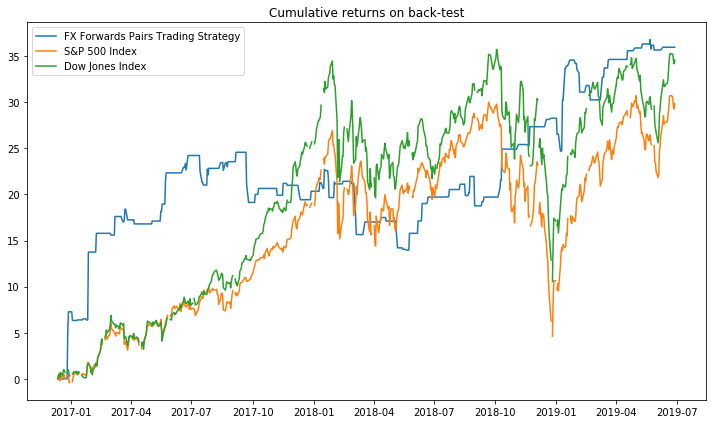

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(cum_ret_df.index, cum_ret_df, label="FX Forwards Pairs Trading Strategy")
plt.plot(cum_ret_snp_df.index, cum_ret_snp_df, label="S&P 500 Index")
plt.plot(cum_ret_dj_df.index, cum_ret_dj_df, label="Dow Jones Index")
plt.title("Cumulative returns on back-test")
plt.legend(loc=2)
plt.tight_layout()
plt.show()

#### Sharpe ratio

In [25]:
US_3M_TBILL = (0.01682, "US 3M TBILL") # Annualised return
AVG_DAILY_RF_RET = (US_3M_TBILL[0]+1)**(1/252)-1 # Daily return

In [26]:
print("\n")
daily_return_df = ((profit_df - profit_df.shift(1))/profit_df.shift(1))
daily_return_snp_df = ((snp_500_df - snp_500_df.shift(1))/snp_500_df.shift(1))
daily_return_dj_df = ((dj_df - dj_df.shift(1))/dj_df.shift(1))
# Annualising daily sharpe ratios
sharpe_ratio_strat = 252**(1/2)*(np.mean(daily_return_df) - AVG_DAILY_RF_RET)/np.std(daily_return_df)
print(f"Sharpe ratio for strategy using {US_3M_TBILL[1]} as risk-free benchmark: {sharpe_ratio_strat[0]}")
sharpe_ratio_snp = 252**(1/2)*(np.mean(daily_return_snp_df) - AVG_DAILY_RF_RET)/np.std(daily_return_snp_df)
print(f"Sharpe ratio for S&P 500 Index using {US_3M_TBILL[1]} as risk-free benchmark: {sharpe_ratio_snp[0]}")
sharpe_ratio_dj = 252**(1/2)*(np.mean(daily_return_dj_df) - AVG_DAILY_RF_RET)/np.std(daily_return_dj_df)
print(f"Sharpe ratio for Dow Jones Index using {US_3M_TBILL[1]} as risk-free benchmark: {sharpe_ratio_dj[0]}")
print("\n")



Sharpe ratio for strategy using US 3M TBILL as risk-free benchmark: 1.1476277048690033
Sharpe ratio for S&P 500 Index using US 3M TBILL as risk-free benchmark: 1.0860498024632759
Sharpe ratio for Dow Jones Index using US 3M TBILL as risk-free benchmark: 1.1034907187853806




#### Other performance metrics

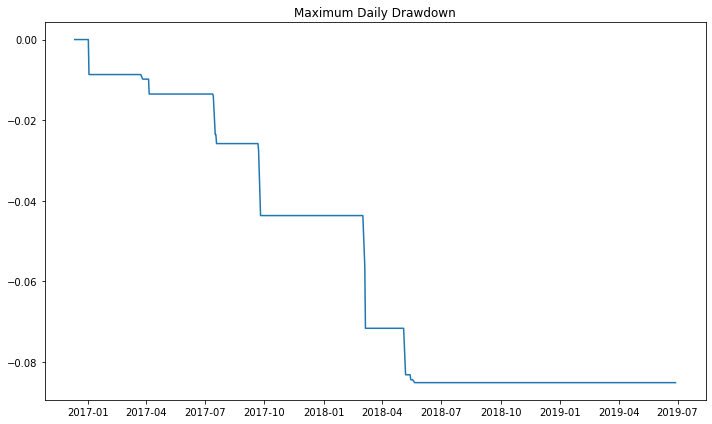

In [27]:
# Print these out individually to reveal value
net_profit = profit_list[-1] - profit_list[0]
net_profit_pct = (profit_list[-1] - profit_list[0])/profit_list[0]
annual_ret = (1 + np.mean(daily_return_df))**252 - 1
win_pct = num_wins/num_trades
avg_profit = sum([i for i in raw_profit_list if i > 0])/num_wins
loss_pct = num_losses/num_trades
avg_loss = sum([i for i in raw_profit_list if i < 0])/num_losses
# Expectancy = (total profit + total loss)/number of trades
expectancy = (sum([i for i in raw_profit_list if i > 0]) + sum([i for i in raw_profit_list if i < 0]))/num_trades

# Maximum drawdown
rolling_max = profit_df.cummax()
daily_drawdown = profit_df/rolling_max - 1
max_daily_drawdown = daily_drawdown.cummin()

plt.figure(figsize=(10,6))
plt.plot(max_daily_drawdown)
plt.title("Maximum Daily Drawdown")
plt.tight_layout()
plt.show()

In [29]:
print("\n")
print(f"Final strategy net value: {net_profit_pct*100}%")
print("\n")
input("Press ENTER to exit: ")



Final strategy net value: 35.96081261171992%


Press ENTER to exit: 


''